## Import libraries

In [1]:
from importlib import reload

import os
import re

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as sk
import os
import re
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

from byc import constants, files, database, segmentation
from byc import standard_analysis as sa
from byc import plotting
from byc import fitting_tools as ft

from byc import constants, plotting, files, database, utilities, trace_tools, fitting_tools, segmentation
from byc import standard_analysis as sa
from byc.trace_tools import median_filter
median_filter
from importlib import reload
for pac in [constants,
            plotting,
            files,
            sa,
            database,
            utilities,
            trace_tools,
            fitting_tools,
            segmentation]:
    reload(pac)
    
plotting.set_styles(plt, matplotlib)

strains_color_dict =  plotting.strains_color_dict
other_colors = plotting.other_colors

# Generate a palette to use for signifying number of 
# buds that will be produced before the last bud
pre_post_SEP_palette = plotting.get_pre_post_sep_palette()

## Read in databases

In [2]:
traces_df, fits_df, buds_df = database.read_in_trace_fits_buds_dfs()

C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (64,66,71,85,89,90,94,96,97,98,99,100,101,102,103,104,105,106,107,108,172,173,175,177,209,213,214,216,217,218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/traces_df.csv.gzip


C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (64,66,83,87,88,141,142,144,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/fits_df.csv.gzip
Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/buds_df.csv.gzip


C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (41,50,51,53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


In [3]:
cols = [col for col in fits_df.columns if fits_df[col].dtype!='O']
cols = cols + ['compartment_name']
print(f'Total cell counts for each compartment:')
fits_df.loc[:, cols][fits_df.strain_name.isin(['JPC121', 'JPC220'])].pivot_table(
    index=['compartment_name'], aggfunc='count').b

Total cell counts for each compartment:


compartment_name
20210910_JPC121_UbiR-YFP_su9x2_in_BYC4741_old_chase     54
20220622_byc_JPC121_two-chase                           42
20220825_byc_JPC121_two-chase_1000xetOH                 62
20220831_byc_JPC220_R-YFP-Su9_HSP104-mCherry            43
20221019_byc_JPC228_UBL-YFP-Su9_full                   112
20221028_byc_JPC228_DsRed-P2A-UBL-YFP-Su9_3x-int        49
20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry           154
20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry           212
20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry           119
Name: b, dtype: int64

Text(0.5, 0, 'Buds before death')

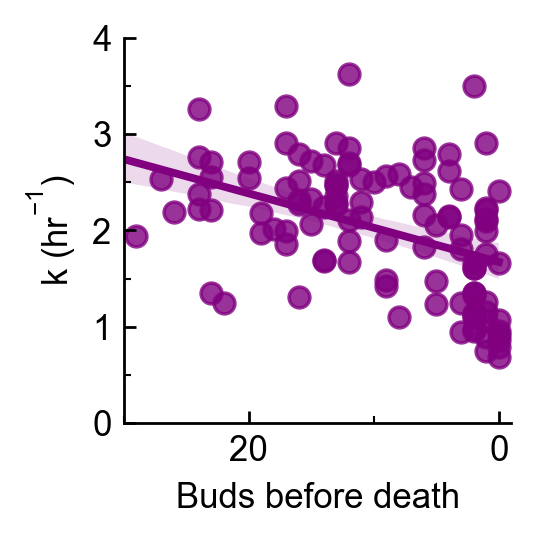

In [4]:
subdf = fits_df[fits_df.compartment_name.isin(['20221019_byc_JPC228_UBL-YFP-Su9_full'])]

fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'dist_from_sen',
    'y': 'b',
    'data': subdf,
    'ax': ax,
    'color': 'purple'
}

sns.regplot(**kwargs)
ax.set_ylim(0, 4) 
ax.set_xlim(30, -1)

plotting.format_ticks(ax)
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.set_xlabel('Buds before death')

In [5]:
fits_df.loc[:, cols][fits_df.strain_name.isin(['JPC121', 'JPC220'])].pivot_table(
    index=['compartment_name'], aggfunc='count').b.sum()

847

In [6]:
cols = [col for col in fits_df.columns if fits_df[col].dtype!='O']
cols = cols + ['contains_aggregate']
fits_df[fits_df.first_crop_frame>100].loc[fits_df.compartment_name=='20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry'].loc[:, cols].groupby('contains_aggregate').count()

,Unnamed: 0,age_at_chase,rls,dist_from_sen,first_bud_frame,cell_index,Mean_yfp_auto,Mean_yfp_auto_bg_sub,a,abs_chase_frame,...,Int_bf_auto,Int_yfp_auto,bf_mean_bg_norm,bf_mean_min_norm,bf_mean_norm_to_mean,.Cell_area_px_rfp_auto,Int_rfp_auto,rfp_mean_bg_sub,rfp_norm,can1delta
contains_aggregate,,,,,,,,,,,,,,,,,,,,,
no,29,29,29,29,29,29,29,29,29,29,...,0,0,0,0,0,0,0,0,0,29
yes,34,34,34,34,34,34,34,34,34,34,...,0,0,0,0,0,0,0,0,0,34


## Figure 5: F0 daughter cell ubiquitin-dependent proteasome substrate turnover declines with mother cell's senescence proximity

State of analysis:

20221019_byc: Have analyzed daughters of cells up throug cell 121 which is all the mothers that have been analyzed. Could analyze more mother cells starting at xy03

20221201_byc: Have analyzed daughters of cells up through cell_index 119 (xy03) which is all the mothers that have been analyzed. Could analyze a lot more cells from this expt starting after cell 119 in xy03

20221118_byc: Have analyzed daughters of cells up through cell 214 xy04 which is all the mothers that have been analyzed. Could analyze more mother cells from this expt starting with xy05

20221104_byc: Have analyzed daughters of cells up through cell 159 which is all the mothers that have been analyzed. Could analyze more mother cells from this expt starting with xy05

### Read in data

In [8]:
daughter_comps = [
    '20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_1stdaughters',
    '20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1st_daughters',
    '20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1st_daughters',
    '20221019_byc_JPC228_UBL-YFP-Su9_full_1st_daughters'
]

mother_comps = [
    '20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry',
    '20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry',
    '20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry',
    '20221019_byc_JPC228_UBL-YFP-Su9_full'
]

mother_table = fits_df[fits_df.compartment_name.isin(mother_comps)]

daughter_dfs = []

for comp in daughter_comps:
    exptname = utilities.exptname_from_compartment(comp)
    compdir = files.get_byc_compartmentdir(exptname, comp)
    path = os.path.join(compdir, 'fits_table.csv')
    df = pd.read_csv(path)
    daughter_dfs.append(df)

daughter_table = pd.concat(daughter_dfs)
daughter_table.loc[:, 'bud_rois_path'] = [os.path.abspath(val) for val in daughter_table.crop_roi_set_path.str.replace('crop_rois', 'bud_rois').values]
if 'level_0' in daughter_table.columns:
    daughter_table.drop(labels='level_0', axis=1, inplace=True)
daughter_table.reset_index(inplace=True)
if 'level_0' in daughter_table.columns:
    daughter_table.drop(labels='level_0', axis=1, inplace=True)

database.set_bud_id(mother_table)
database.set_bud_id(daughter_table)
# Keep only chase 2 measurement in case there are some cells
# which were also measured at chase 1
mother_table = mother_table[mother_table.first_crop_frame>100]

C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:413: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'bud_id'] = np.nan
C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'compartment-bud_id'] = np.nan


In [9]:
# Get the mother rate constant for each daughter cell
# Report where daughter cells have no corresponding mother cell
# It's likely that the mother is missing from the database because
# it fit poorly and was thrown out
for idx in daughter_table.index.unique():
    bud_id = daughter_table.loc[idx, 'bud_id']
    if bud_id in mother_table.bud_id.unique():
        mother_rate = mother_table.loc[mother_table.bud_id==bud_id, 'b'].values[0]
        mother_contains_aggregate = mother_table.loc[mother_table.bud_id==bud_id, 'contains_aggregate'].values[0]
        mother_dist_from_sen = mother_table.loc[mother_table.bud_id==bud_id, 'dist_from_sen'].values[0]
        daughter_table.loc[idx, 'mother_b'] = mother_rate
        daughter_table.loc[idx, 'mother_contains_aggregate'] = mother_contains_aggregate
        daughter_table.loc[idx, 'mother_dist_from_sen'] = mother_dist_from_sen
    else:
        tableslice = daughter_table.loc[idx, ['compartment_name', 'cell_index']]
        print(f'No mother cell with matching bud_id to daughter\n{tableslice}')
        daughter_table.loc[idx, 'mother_b'] = np.nan

No mother cell with matching bud_id to daughter
compartment_name    20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...
cell_index                                                          3
Name: 32, dtype: object
No mother cell with matching bud_id to daughter
compartment_name    20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...
cell_index                                                         33
Name: 104, dtype: object
No mother cell with matching bud_id to daughter
compartment_name    20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...
cell_index                                                         18
Name: 106, dtype: object
No mother cell with matching bud_id to daughter
compartment_name    20221019_byc_JPC228_UBL-YFP-Su9_full_1st_daugh...
cell_index                                                         22
Name: 118, dtype: object
No mother cell with matching bud_id to daughter
compartment_name    20221019_byc_JPC228_UBL-YFP-Su9_full_1st_daugh...
cell_index                     

### Look at how many more daughter cells the mother was to produce after the measured daughter cell was born

In [ ]:
fig, ax = plotting.figure_ax()
# subtable = daughter_table[daughter_table.dist_from_sen==daughter_table.mother_dist_from_sen]
subtable = daughter_table
ax.scatter(subtable.dist_from_sen, subtable.mother_dist_from_sen, alpha=0.2)
x = np.arange(0, 20, 0.5)
y = ft.line(x, 1, 0)
ax.plot(x, y)

ax.set_xlabel('Mother dist from sen\nwhen daughter born')
ax.set_ylabel('Mother dist from sen at chase')

ax.set_xlim(0, 25)
ax.set_ylim(0, 25)
ax.set_xticks(np.arange(0, 25.1, 5))

plotting.format_ticks(ax)

plotting.save_figure(fig, {'x': 'mother_dist_from_sen_at_birth', 'y':'mother_dist_from_sen_at_chase'}, ext='.svg')

### Representative trace plots

In [6]:
# Cell 8 is a good fast mother and daughter
# Cell 6 is a good fast mother and daughter
for cell_index in wanted_mother_cell_indices:
    subdf = fits_df_md[fits_df_md.cell_index==cell_index]
    dist_from_sen = int(subdf.dist_from_sen.iloc[0])
    colors = sns.color_palette('viridis', max_dist_from_sen+1)
    colors_list = [c for c in colors]
    colors_list.reverse()
    color = colors_list[dist_from_sen]
    fig, ax = plotting.figure_ax()
    fig.set_dpi(300)
    linekwargs = {
        'x': 'x_input',
        'y': 'y_pred_norm',
        'style': 'mother_daughter',
        'style_order': ['mother', 'daughter'],
        'data': subdf,
        'ax': ax,
        'color': color
    }

    sns.lineplot(**linekwargs)

    scatterkwargs = {
        'x': 'x_input',
        'y': 'y_pred_norm',
        'style': 'mother_daughter',
        'style_order': ['mother', 'daughter'],
        'data': subdf,
        'ax': ax,
        'color': colors_list[dist_from_sen]
    }

    sns.scatterplot(**scatterkwargs)

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.2)
    plotting.format_ticks(ax)
    plotting.legend_outside()

    ax.set_xlabel('Hours after chase')
    ax.set_ylabel('YFP/YFP(t0)')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='o', color=color, lw=2),
                    Line2D([0], [0], marker='x', linestyle='--', color=color, lw=2),]

    ax.legend(custom_lines, ['Mother cell', 'Daughter cell'], frameon=False, loc='best')
    print(f'Rates {fits_df_md[fits_df_md.cell_index==cell_index].b.unique()}')
    plt.tight_layout()
    filetype = '.png'
    filename = f'meta/plots/{exptname}_cell{cell_index}_mother-daughter_dist_from_sen={dist_from_sen}{filetype}'
    savepath = os.path.abspath(os.path.join(constants.byc_data_dir, filename))
    fig.savefig(savepath)
    print(f'Saved figure at\n{savepath}')
    plt.close(fig)

NameError: name 'wanted_mother_cell_indices' is not defined

### Mother vs. daughter decay rate scatter plot

In [7]:
repeat_mother_bs = []
for b in daughter_table.mother_b.unique():
    l = len(daughter_table[daughter_table.mother_b==b])
    if l > 1:
        repeat_mother_bs.append(b)

In [8]:
mother_table[mother_table.b.isin(repeat_mother_bs)].loc[:, ['compartment_name', 'cell_index']].sort_values(by='cell_index')

,compartment_name,cell_index
2455,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,70.0
2452,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,77.0
2487,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,79.0
2506,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,121.0


In [9]:
daughter_table[daughter_table.mother_b.isin(repeat_mother_bs)].loc[:, ['compartment_name', 'cell_index']].sort_values(by='cell_index')

,compartment_name,cell_index
36,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,18
37,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,19
33,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,22
30,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,23
50,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,24
54,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,25
65,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,37
61,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry_1...,38


### Daughter k vs. mother k

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=mother_b_y=b_hue=mother_dist_from_sen.svg
0.48 of total were faster daughters


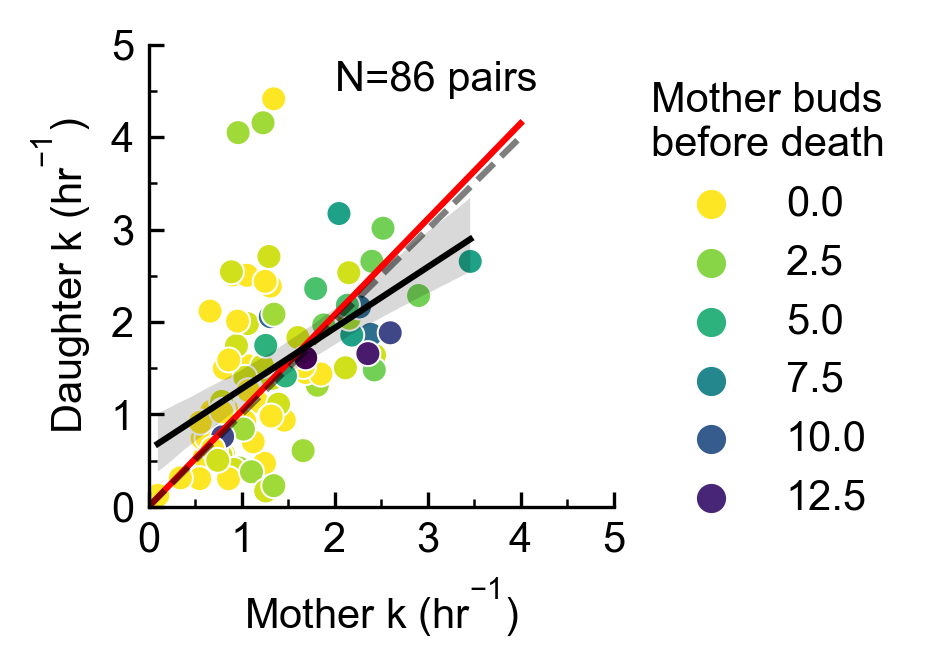

In [13]:
from lmfit.model import ModelResult
from lmfit import Model
from lmfit import Parameters

fig, ax = plotting.figure_ax()
fig.set_dpi(300)

subtable = daughter_table[daughter_table.mother_b.isna()==False]
subtable = subtable[subtable.dist_from_sen==subtable.mother_dist_from_sen]
# Get rid of entries where there are more than one daughter measured per
# mother cell
# subtable = subtable[subtable.dist_from_sen<=5]
# subtable = subtable[subtable.mother_contains_aggregate=='no']
repeat_mother_bs = []
for b in subtable.mother_b.unique():
    l = len(subtable[subtable.mother_b==b])
    if l > 1:
        repeat_mother_bs.append(b)
subtable = subtable[~subtable.mother_b.isin(repeat_mother_bs)]

linewidth = 1
fontsize = 10

kwargs = {
    'x': 'mother_b',
    'y': 'b',
    'hue': 'mother_dist_from_sen',
    'palette': 'viridis_r',
    'ax': ax,
    'data': subtable[subtable.mother_dist_from_sen>=0]
}

regkwargs = {
    'x': 'mother_b',
    'y': 'b',
    'ax': ax,
    'data': subtable[subtable.mother_dist_from_sen>=0],
    'scatter': False,
    'color': 'black',
    'line_kws': {'linewidth':1.5}
}

linear_model = Model(fitting_tools.line)
params = Parameters()
manual_bootstrap=False
guesses = {
    'm': 1,
    'b': 0
}
varies = {
    'm': True,
    'b': False
}
for key, val in guesses.items():
    params.add(key, value=guesses[key], vary=varies[key])
result = linear_model.fit(subtable[kwargs['y']], params, x=subtable[kwargs['x']])
fitsdf = fitting_tools.df_from_ModelResult(result)

x = np.arange(0, 4.1, 0.1)
y = fitting_tools.line(x, fitsdf.m.iloc[0], fitsdf.b.iloc[0])
ax.plot(x, y, color='red', alpha=1)
# now bootstrap the error on the above fit
if manual_bootstrap:
    for i in range(1000):
        sample = subtable.sample(n=int(np.round(len(subtable)/2, 0)), replace=False)
        result = linear_model.fit(sample[kwargs['y']], params, x=sample[kwargs['x']])
        fitsdf = fitting_tools.df_from_ModelResult(result)

        x = np.arange(0, 4.1, 0.1)
        y = fitting_tools.line(x, fitsdf.m.iloc[0], fitsdf.b.iloc[0])
        ax.plot(x, y, color='red', alpha=0.005)
# Not plotting my fit because I want to show 95% CI which I believe is 
# bootstrapped in sns.regplot()
ax.plot(x, fitting_tools.line(x, 1, 0), color='black', alpha=0.5, linestyle='--')


sns.scatterplot(**kwargs)
sns.regplot(**regkwargs)
legend = ax.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], title='Mother buds\nbefore death', frameon=False,
                  bbox_to_anchor=(1, 1))
# ax.legend_.set_visible(False)
ax.set_xticks(np.arange(0, 5.1, 1))
ax.set_yticks(np.arange(0, 5.1, 1))
ax.set_xlabel(f'Mother {plotting.annoying_strings().k_inverse_hrs}', fontsize=fontsize)
ax.set_ylabel(f'Daughter {plotting.annoying_strings().k_inverse_hrs}', fontsize=fontsize)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
plotting.format_ticks(ax)
n_pairs = len(kwargs['data'])
n_string = f'N={n_pairs} pairs'
ax.annotate(n_string, xy=(2, 4.5))

plotting.save_figure(fig, kwargs, ext='.svg')
comparetable = regkwargs['data']
print(f'{np.round(len(comparetable[comparetable.mother_b<comparetable.b])/len(comparetable), 2)} of total were faster daughters')

### Residual from y = mx + 0 fit

In [1]:
from lmfit.model import ModelResult
from lmfit import Model
from lmfit import Parameters

fig, ax = plotting.figure_ax()
fig.set_dpi(600)
color = 'red'
subtable = daughter_table[daughter_table.mother_b.isna()==False]
subtable = subtable[subtable.dist_from_sen==subtable.mother_dist_from_sen]
# Get rid of entries where there are more than one daughter measured per
# mother cell
# subtable = subtable[subtable.dist_from_sen<=5]
# subtable = subtable[subtable.mother_contains_aggregate=='no']
repeat_mother_bs = []
for b in subtable.mother_b.unique():
    l = len(subtable[subtable.mother_b==b])
    if l > 1:
        repeat_mother_bs.append(b)
subtable = subtable[~subtable.mother_b.isin(repeat_mother_bs)]

linewidth = 1
fontsize = 10

subtable.loc[:, 'y_pred'] = fitting_tools.line(subtable[regkwargs['x']], result.values['m'], result.values['b'])
subtable.loc[:, 'residual'] = subtable.b - subtable.y_pred

regkwargs = {
    'x': 'mother_b',
    'y': 'residual',
    'data': subtable,
    'ax': ax,
    'color': color,
    'scatter_kws': {'alpha': 0.3},
    'line_kws': {'linewidth': 1}
}
sns.regplot(**regkwargs)
ax.set_xlim(0, 4)
ax.set_ylim(-2, 4)
plotting.format_ticks(ax)
ax.axhline(0, linewidth=1, color='black')
plotting.save_figure(fig, regkwargs, ext='.svg')

NameError: name 'plotting' is not defined

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\y=residual_color=red_kde=True_bins=20.svg


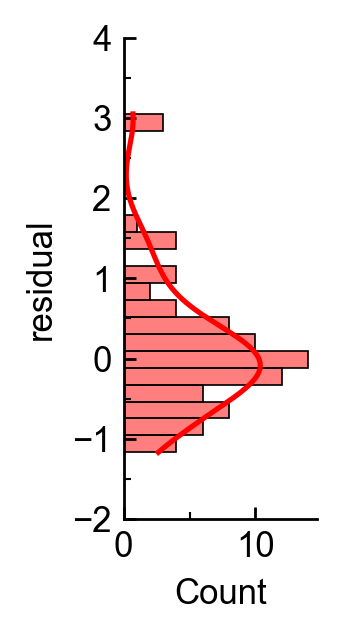

In [234]:
fig, ax = plotting.figure_ax(width_scale=0.4)

ax.set_ylim(-2, 4)
ax.set_yticks(np.arange(-2, 4.1, 1))

kwargs = {
    'y': 'residual',
    'ax': ax,
    'color': color,
    'data': subtable,
    'kde': True,
    'bins': 20
}

# ax.hist(subtable.residual, bins=30, density=True, color=color, alpha=0.5)
sns.histplot(**kwargs)
plotting.format_ticks(ax)

plotting.save_figure(fig, kwargs, ext='.svg')

#### Residual from y = mx + b fit

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=mother_b_y=b_hue=dist_from_sen.svg
0.48 of total were faster daughters


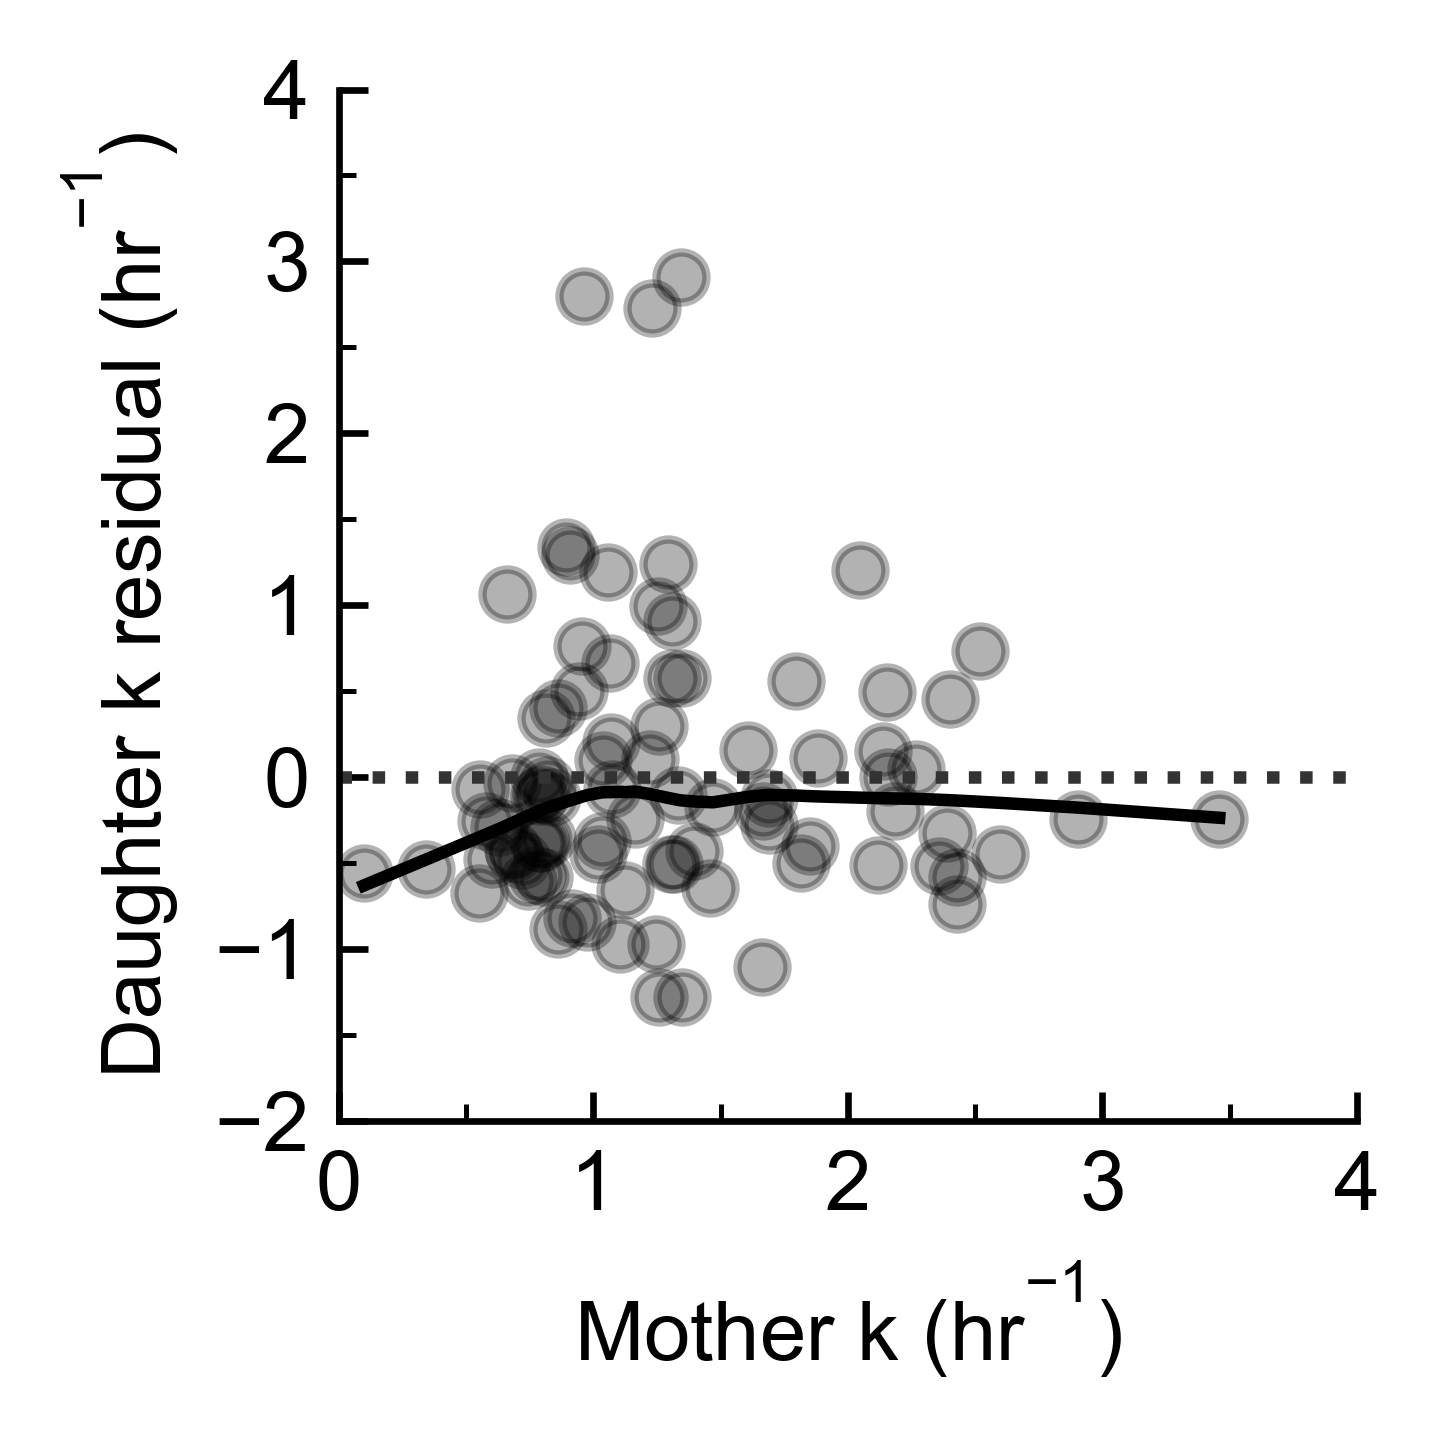

In [77]:
from lmfit.model import ModelResult
from lmfit import Model
from lmfit import Parameters

fig, ax = plotting.figure_ax()
fig.set_dpi(600)

subtable = daughter_table[daughter_table.mother_b.isna()==False]
subtable = subtable[subtable.dist_from_sen==subtable.mother_dist_from_sen]
# Get rid of entries where there are more than one daughter measured per
# mother cell
# subtable = subtable[subtable.dist_from_sen<=5]
# subtable = subtable[subtable.mother_contains_aggregate=='no']
repeat_mother_bs = []
for b in subtable.mother_b.unique():
    l = len(subtable[subtable.mother_b==b])
    if l > 1:
        repeat_mother_bs.append(b)
subtable = subtable[~subtable.mother_b.isin(repeat_mother_bs)]

linewidth = 1
fontsize = 10

regkwargs = {
    'x': 'mother_b',
    'y': 'b',
    'ax': ax,
    'data': subtable,
    'color': 'black',
    'line_kws': {'linewidth':1.5},
    'scatter_kws': {'alpha': 0.3},
    'lowess': True
}

sns.residplot(**regkwargs)
ax.set_xlabel(f'Mother {plotting.annoying_strings().k_inverse_hrs}', fontsize=fontsize)
ax.set_ylabel(f'Daughter k residual {plotting.annoying_strings().k_inverse_hrs[2:]}', fontsize=fontsize)

ax.set_xlim(0, 4)
ax.set_ylim(-2, 4)

ax.set_xticks(np.arange(0, 4.1, 1))

plotting.format_ticks(ax)
n_pairs = len(subtable)
n_string = f'N={n_pairs} pairs'
ax.annotate(n_string, xy=(2, 4.5))
plt.tight_layout()
plt.tight_layout()
plotting.save_figure(fig, kwargs, ext='.svg')

print(f'{np.round(len(subtable[subtable.mother_b<subtable.b])/len(subtable), 2)} of total were faster daughters')

### Daughter minus mother plot

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=mother_b_y=daughter_minus_mother_hue=mother_dist_from_sen.svg
0.48 of total were faster daughters


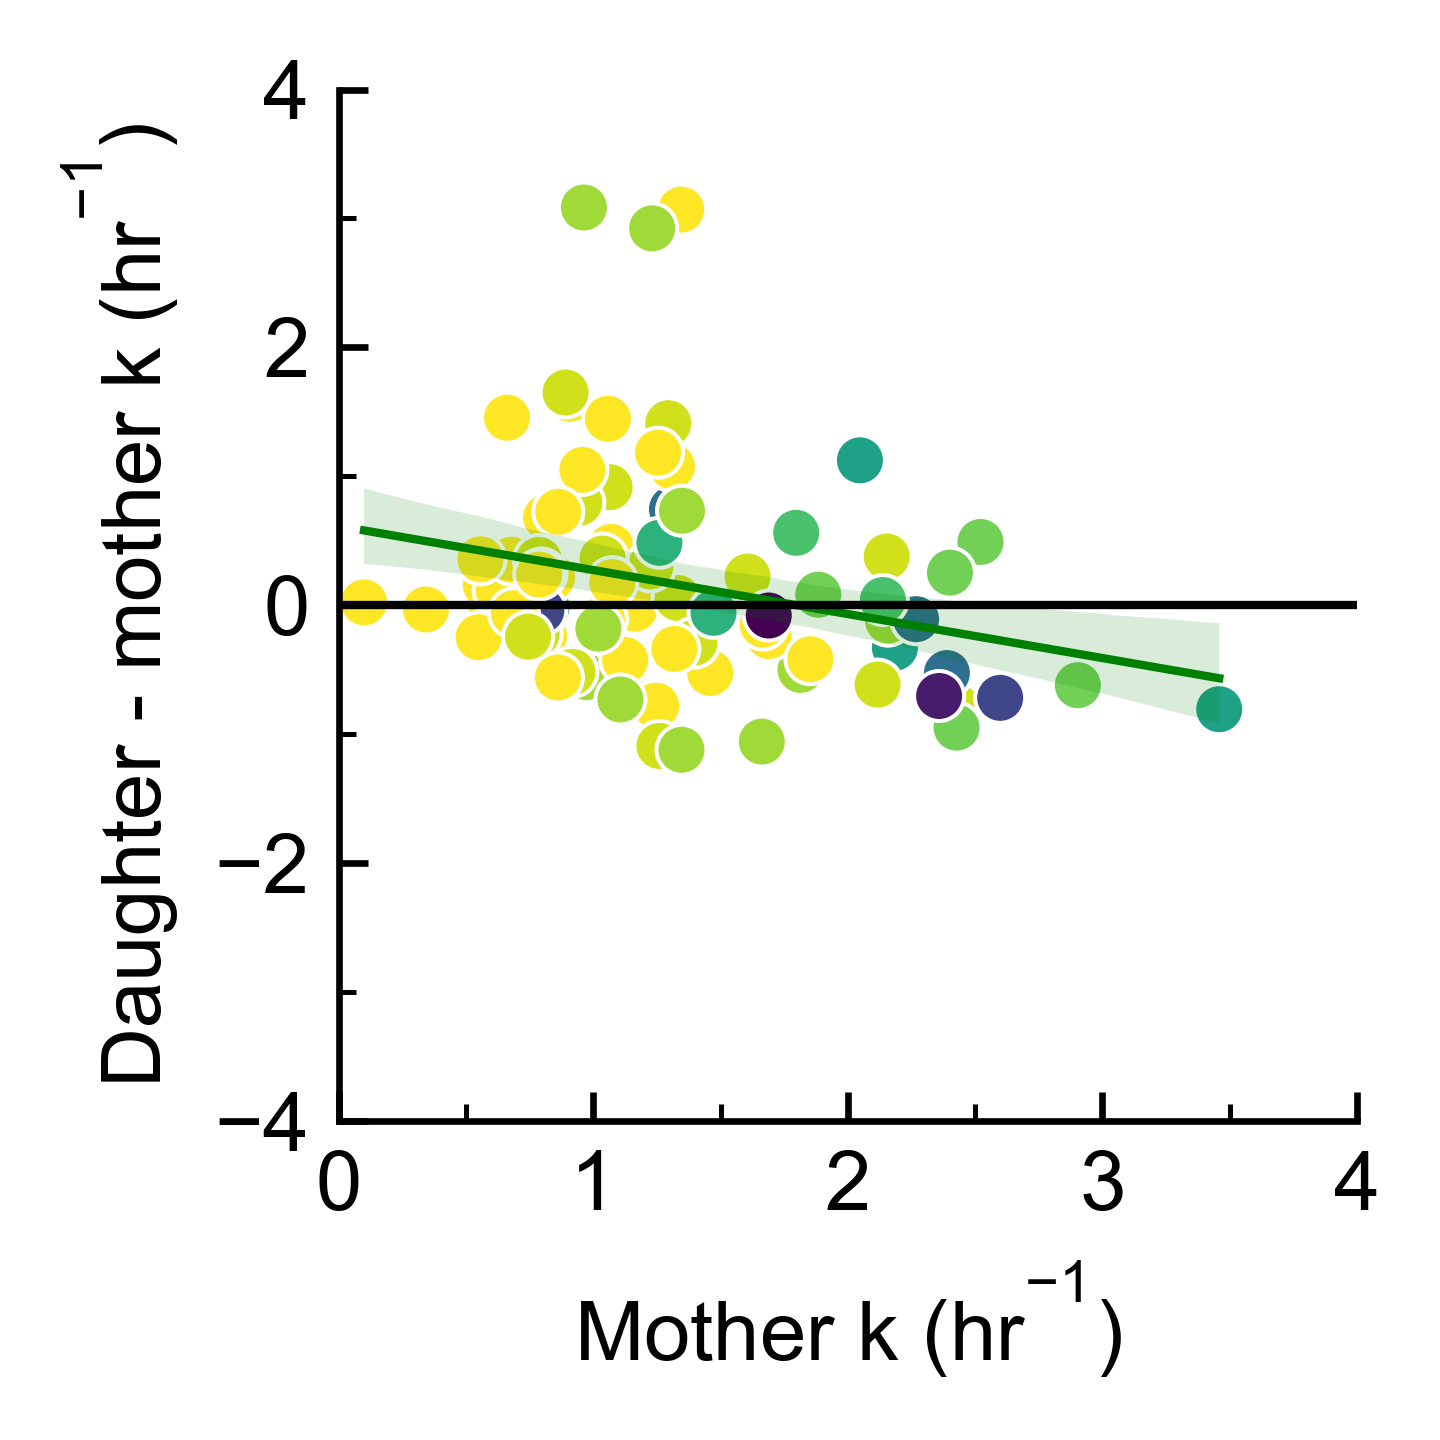

In [143]:
from lmfit.model import ModelResult
from lmfit import Model
from lmfit import Parameters

fig, ax = plotting.figure_ax()
fig.set_dpi(600)

subtable = daughter_table[daughter_table.mother_b.isna()==False]
subtable = subtable[subtable.dist_from_sen==subtable.mother_dist_from_sen]
subtable.loc[:, 'daughter_minus_mother'] = subtable.b - subtable.mother_b
# Get rid of entries where there are more than one daughter measured per
# mother cell
# subtable = subtable[subtable.dist_from_sen<=5]
# subtable = subtable[subtable.mother_contains_aggregate=='no']
repeat_mother_bs = []
for b in subtable.mother_b.unique():
    l = len(subtable[subtable.mother_b==b])
    if l > 1:
        repeat_mother_bs.append(b)
subtable = subtable[~subtable.mother_b.isin(repeat_mother_bs)]

linewidth = 1
fontsize = 10

kwargs = {
    'x': 'mother_b',
    'y': 'daughter_minus_mother',
    'hue': 'mother_dist_from_sen',
    'ax': ax,
    'data': subtable,
    'palette': 'viridis_r'
}

linekwargs = {
    'x': 'mother_b',
    'y': 'daughter_minus_mother',
    'ax': ax,
    'data': subtable,
    'color': 'green',
    'scatter': False,
    'line_kws': {'linewidth': 1}
}

sns.scatterplot(**kwargs)
sns.regplot(**linekwargs)
ax.set_xlabel(f'Mother {plotting.annoying_strings().k_inverse_hrs}', fontsize=fontsize)
ax.set_ylabel(f'Daughter - mother k {plotting.annoying_strings().k_inverse_hrs[2:]}', fontsize=fontsize)

ax.set_xlim(0, 4)
ax.set_ylim(-4, 4)

ax.set_xticks(np.arange(0, 4.1, 1))
ax.legend_.set_visible(False)
ax.axhline(0, linewidth=1, color='black')
plotting.format_ticks(ax)
n_pairs = len(subtable)
n_string = f'N={n_pairs} pairs'
ax.annotate(n_string, xy=(2, 4.5))
plt.tight_layout()
plt.tight_layout()
plotting.save_figure(fig, kwargs, ext='.svg')

print(f'{np.round(len(subtable[subtable.mother_b<subtable.b])/len(subtable), 2)} of total were faster daughters')

0.48 of total were faster daughters


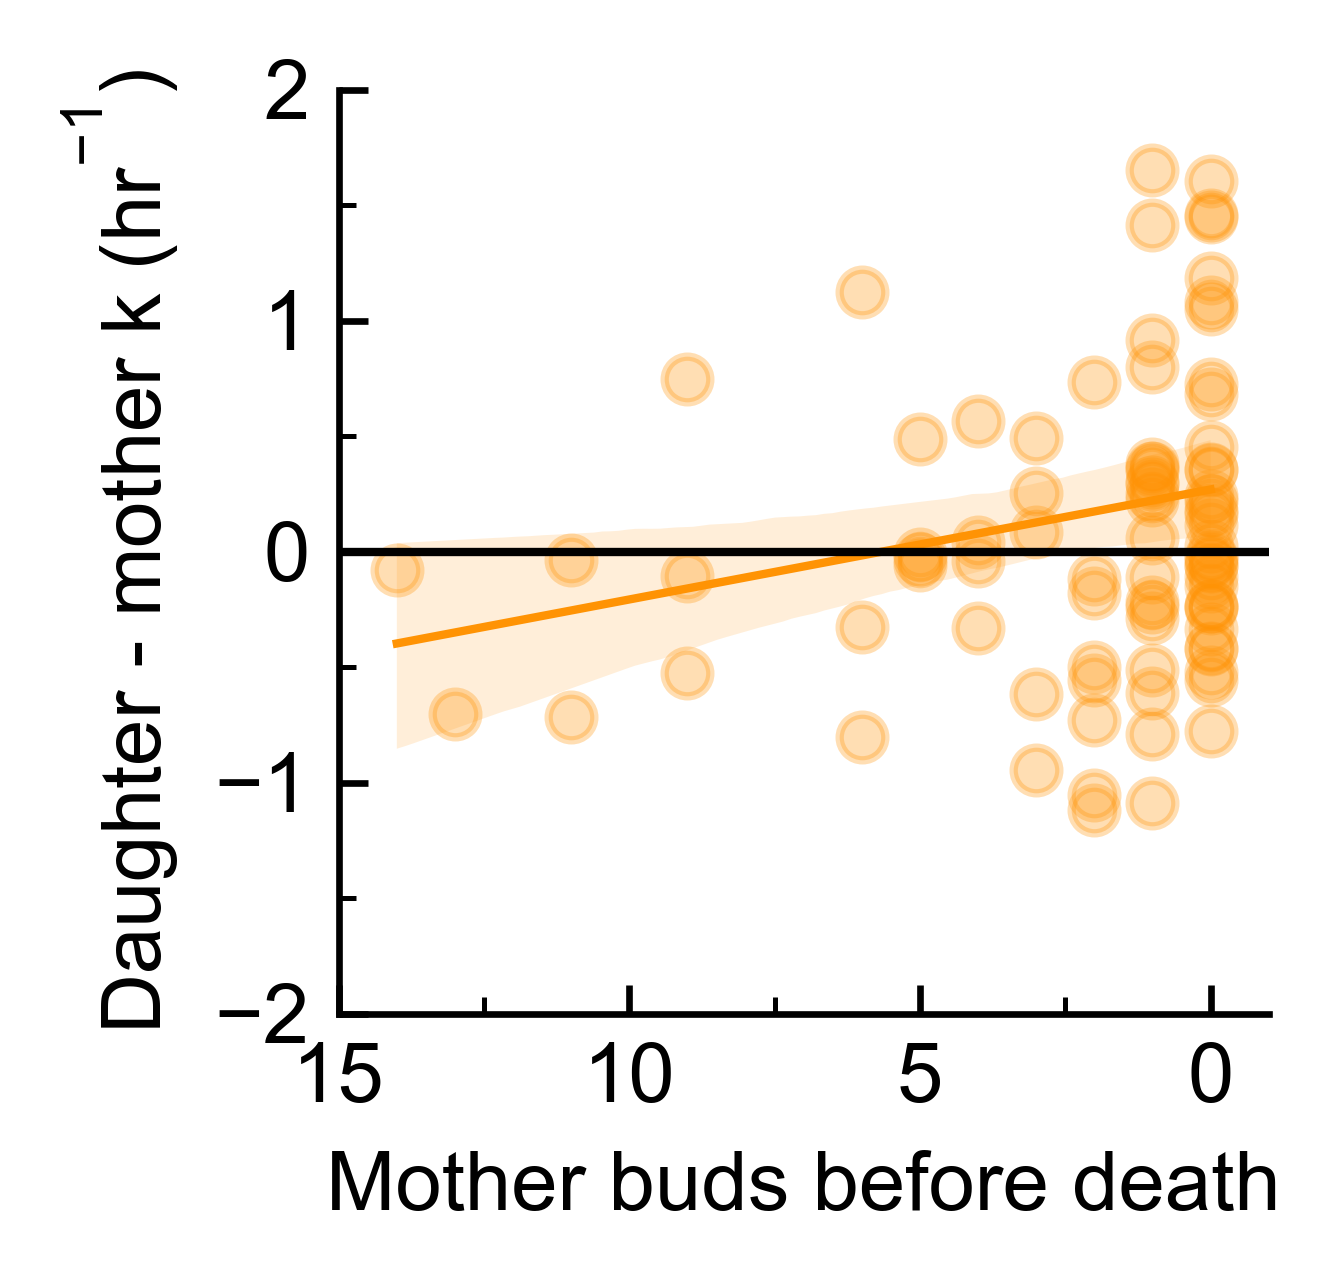

In [25]:
from lmfit.model import ModelResult
from lmfit import Model
from lmfit import Parameters

fig, ax = plotting.figure_ax()
fig.set_dpi(600)

subtable = daughter_table[daughter_table.mother_b.isna()==False]
subtable = subtable[subtable.dist_from_sen==subtable.mother_dist_from_sen]
subtable.loc[:, 'daughter_minus_mother'] = subtable.b - subtable.mother_b
# Get rid of entries where there are more than one daughter measured per
# mother cell
# subtable = subtable[subtable.dist_from_sen<=5]
# subtable = subtable[subtable.mother_contains_aggregate=='no']
repeat_mother_bs = []
for b in subtable.mother_b.unique():
    l = len(subtable[subtable.mother_b==b])
    if l > 1:
        repeat_mother_bs.append(b)
subtable = subtable[~subtable.mother_b.isin(repeat_mother_bs)]

linewidth = 1
fontsize = 10

linekwargs = {
    'x': 'dist_from_sen',
    'y': 'daughter_minus_mother',
    'ax': ax,
    'data': subtable,
    'color': ratecolor,
    'scatter': True,
    'line_kws': {'linewidth': 1},
    'scatter_kws': {'alpha': 0.3, 's': 30}
}

boxkwargs = {
    'x': 'dist_from_sen',
    'y': 'daughter_minus_mother',
    'ax': ax,
    'data': subtable,
    'color': 'green',
    'showfliers': False
}

sns.regplot(**linekwargs)
# sns.boxplot(**boxkwargs)
ax.set_xlabel(f'Mother buds before death', fontsize=fontsize)
ax.set_ylabel(f'Daughter - mother k {plotting.annoying_strings().k_inverse_hrs[2:]}', fontsize=fontsize)

ax.set_xlim(15, -1)
ax.set_ylim(-2, 2)
xticks = list(np.arange(0, 15.1, 5))
xticks.reverse()
ax.set_xticks(xticks)
ax.axhline(0, linewidth=1, color='black')
plotting.format_ticks(ax)
n_pairs = len(subtable)
n_string = f'N={n_pairs} pairs'
plotting.transparent_boxes(ax)
ax.annotate(n_string, xy=(2, 4.5))

# plotting.save_figure(fig, kwargs, ext='.svg')

print(f'{np.round(len(subtable[subtable.mother_b<subtable.b])/len(subtable), 2)} of total were faster daughters')

Saved figure at
c:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\gen_from_death_color_palette_max_dist_from_sen=22.svg


C:\Users\johnp\Dropbox\Projects\byc\byc\plotting.py:1078: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


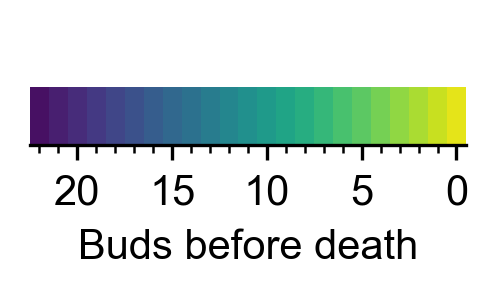

In [73]:
colors = []
for path in ax.get_legend_handles_labels()[0]:
    color = path.get_facecolor()
    colors.append(color)

max_dist_from_sen=subtable.dist_from_sen.max()

plotting.plot_dist_from_sen_palette_key(max_dist_from_sen=int(max_dist_from_sen), major_tick_space=5)

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\20221019_byc_Mother_vs_daughter_All_k_and_cycle_vs._dist_from_sen_filledsep=False_fittype=median.png


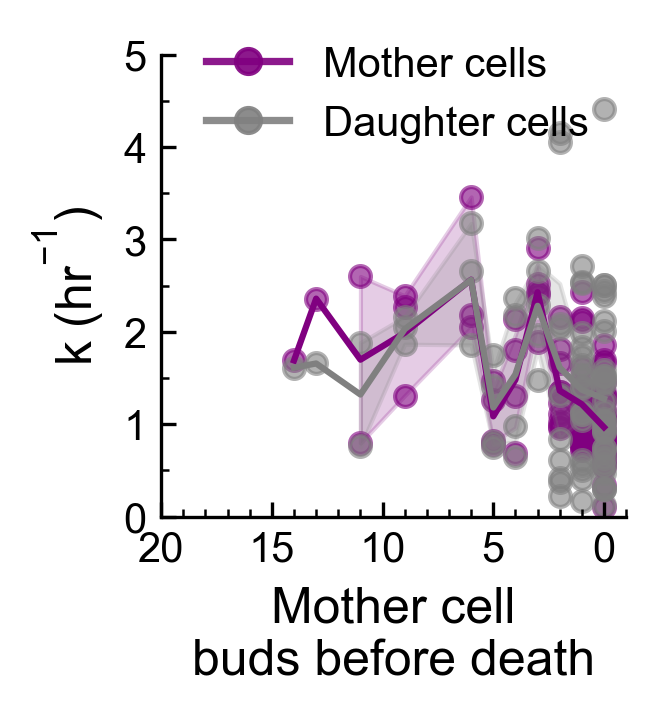

In [28]:
strains = ['JPC121']
strain_name  = strains[0]
mother_subtable = mother_table[mother_table.bud_id.isin(subtable.bud_id.unique())]

linealpha = 0.9
ratecolor = strains_color_dict[strains[0]]
pre_post_SEP_palette = [
    (42/255, 212/255, 255/255),
    (153/255, 153/255, 153/255)
]

fit_type = 'median'
shade_stderr = False
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs_meanfilt_3'
xvar = 'dist_from_sen'
alpha = 0.785
size = 15
fontsize=12
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Mother cell\nbuds before death'

styles = ['-', '--']
markers = ['o', 'x']
colors = ['purple', 'gray']
for i, sub_fits_df in enumerate([mother_subtable, subtable]):
    sub_fits_df.loc[:, 'strain_name'] = 'JPC220'
    if fillsep:
        # Shade post-SEP area
        xfill = np.arange(-1, 7, 1)
        ax.fill_between(
            xfill,
            np.full(len(xfill), 4),
            color=pre_post_SEP_palette[1],
            alpha=fillalpha,
            edgecolor=None)
        # Shade post-SEP area
        xfill = np.arange(7, 26, 1)
        ax.fill_between(
            xfill,
            np.full(len(xfill), 4),
            color=pre_post_SEP_palette[0],
            alpha=fillalpha,
            edgecolor=None)

    if fit_type=='logistic':
        # fit to logistic
            fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
            kernsize = 3
            trace_tools.mean_filter(
                smoothdf,
                'stderr',
                kernsize,
                name_with_kernel=True)  

            params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
            x = np.sort(sub_fits_df[xvar].unique())
            y_pred = fitting_tools.logistic(x, *params)
    elif fit_type=='line':
        # Fit to line
        fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
        y_pred = fitting_tools.line(x, *params)
        
    elif fit_type=='median':
        sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=colors[i])

    else:
        print(f'No fit type <{fit_type}>. Please use either logistic or line')
    # Derive statistics of fit
    r_sq = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df)
    n = len(sub_fits_df)
    # Shade standard error of the mean for 
    if shade_stderr:
        xvar_fill = 'x_input_smooth'
        yvar_fill = 'y_pred'
        errvar = f'stderr_meanfilt_{kernsize}'
        # errvar = f'stderr'

        err_kwargs = {
            'x': smoothdf[xvar_fill],
            'y1': smoothdf[yvar_fill] + smoothdf[errvar],
            'y2': smoothdf[yvar_fill] - smoothdf[errvar]}

        kwargs = {
            'x': xvar_fill,
            'y': 'y_pred',
            'data': smoothdf,
            'err_kws': err_kwargs}
        ax.fill_between(
            err_kwargs['x'],
            err_kwargs['y1'],
            err_kwargs['y2'],
            color=colors[i],
            alpha=0.2
            )
    # Formatting stuff
    ax.set_xlim(20, -1)
    ax.set_xticks([20, 15, 10, 5, 0])
    ax.set_ylim(0, 5)

    ax.scatter(sub_fits_df[xvar], sub_fits_df[yvar1],
            color=colors[i], alpha=0.6, s=25)
    if fit_type != 'median':
        ax.plot(x, y_pred, color=colors[i], alpha=linealpha)

    plotting.remove_spines(ax)
    plotting.format_ticks(ax, xminorspace=1)

    ax.set_ylabel(ylabel2, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)

    # # Annotate stats
    # xy_n = (23, 3.5)
    # xy_rsq = (23, 3.05)
    # rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 3)}'
    # n_str = f'N={np.round(n, 2)} cells'
    # ax.annotate(rsq_str, xy_rsq)
    # ax.annotate(n_str, xy_n)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], marker='o', alpha=linealpha, lw=1.75),
                Line2D([0], [0], color=colors[1], marker='o', alpha=linealpha, lw=1.75)]
bbox = (0.2, 0.7, 0.8, 0.4)
ax.legend(custom_lines, ['Mother cells', 'Daughter cells'], frameon=False, bbox_to_anchor=bbox)
savedir = os.path.join(constants.byc_data_dir, 'meta/plots/')
savepath = os.path.join(savedir, f'{exptname}_Mother_vs_daughter_{daughter_shape}_k_and_cycle_vs._dist_from_sen_filledsep={fillsep}_fittype={fit_type}.png')
# plt.tight_layout()
fig.savefig(savepath)
print(f'Saved figure at\n{os.path.abspath(savepath)}')

NameError: name 'fits_df_md' is not defined

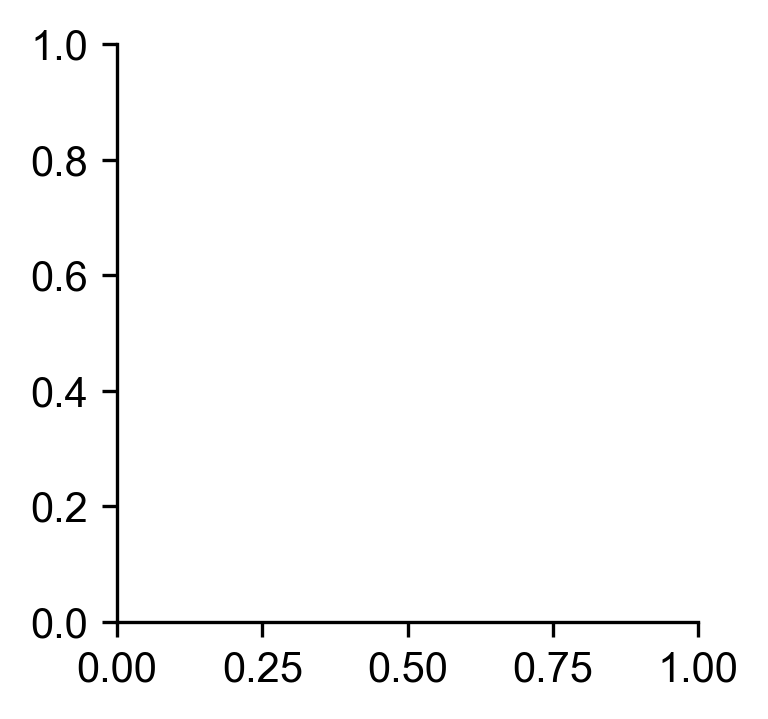

In [27]:
# Cell 8 is a good fast mother and daughter
# Cell 16 is a good fast mother and daughter
# Cell 25
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
cell_index = 39
linekwargs = {
    'x': 'x_input',
    'y': 'y_input_norm',
    'style': 'mother_daughter',
    'hue': 'cell_index',
    'data': fits_df_md[fits_df_md.cell_index==cell_index],
    'ax': ax,
    'palette': 'rainbow'
}

sns.lineplot(**linekwargs)

ax.set_xlim(0, 2)
ax.set_ylim(0, 1.2)
plotting.format_ticks(ax)
plotting.legend_outside()

ax.set_xlabel('Hours after chase')
ax.set_ylabel('YFP/YFP(t0)')